In [80]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import geopandas as gpd
import contextily as ctx
from shapely.geometry import Point
import seaborn as sns
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.impute import KNNImputer
import xgboost as xgb
from sklearn.model_selection import train_test_split
plt.style.use('ggplot')


In [5]:
# !pip install geopandas
# !pip install descartes
# !pip install contextily
# !pip install scikit-learn
# !pip install xgboost


## Reading data
### Note we do not have to extract the zip file

In [2]:
melbourne_housing_raw = pd.read_csv('melbourne-housing-snapshot.zip', compression='zip')
melbourne_housing_raw.tail()

,Suburb,Address,Rooms,Type,Price,Method,SellerG,Date,Distance,Postcode,...,Bathroom,Car,Landsize,BuildingArea,YearBuilt,CouncilArea,Lattitude,Longtitude,Regionname,Propertycount
13575,Wheelers Hill,12 Strada Cr,4,h,1245000.0,S,Barry,26/08/2017,16.7,3150.0,...,2.0,2.0,652.0,NaN,1981.0,NaN,-37.90562,145.16761,South-Eastern Metropolitan,7392.0
13576,Williamstown,77 Merrett Dr,3,h,1031000.0,SP,Williams,26/08/2017,6.8,3016.0,...,2.0,2.0,333.0,133.0,1995.0,NaN,-37.85927,144.87904,Western Metropolitan,6380.0
13577,Williamstown,83 Power St,3,h,1170000.0,S,Raine,26/08/2017,6.8,3016.0,...,2.0,4.0,436.0,NaN,1997.0,NaN,-37.85274,144.88738,Western Metropolitan,6380.0
13578,Williamstown,96 Verdon St,4,h,2500000.0,PI,Sweeney,26/08/2017,6.8,3016.0,...,1.0,5.0,866.0,157.0,1920.0,NaN,-37.85908,144.89299,Western Metropolitan,6380.0
13579,Yarraville,6 Agnes St,4,h,1285000.0,SP,Village,26/08/2017,6.3,3013.0,...,1.0,1.0,362.0,112.0,1920.0,NaN,-37.81188,144.88449,Western Metropolitan,6543.0


## Step 0, is always getting to understand the data
### describe does not always 'describe' the data well,visual representation always helps
### Note: df.describe() works with numeric data columns only

In [3]:
melbourne_housing_raw.describe()

,Rooms,Price,Distance,Postcode,Bedroom2,Bathroom,Car,Landsize,BuildingArea,YearBuilt,Lattitude,Longtitude,Propertycount
count,13580.000000,1.358000e+04,13580.000000,13580.000000,13580.000000,13580.000000,13518.000000,13580.000000,7130.000000,8205.000000,13580.000000,13580.000000,13580.000000
mean,2.937997,1.075684e+06,10.137776,3105.301915,2.914728,1.534242,1.610075,558.416127,151.967650,1964.684217,-37.809203,144.995216,7454.417378
std,0.955748,6.393107e+05,5.868725,90.676964,0.965921,0.691712,0.962634,3990.669241,541.014538,37.273762,0.079260,0.103916,4378.581772
min,1.000000,8.500000e+04,0.000000,3000.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1196.000000,-38.182550,144.431810,249.000000
25%,2.000000,6.500000e+05,6.100000,3044.000000,2.000000,1.000000,1.000000,177.000000,93.000000,1940.000000,-37.856822,144.929600,4380.000000
50%,3.000000,9.030000e+05,9.200000,3084.000000,3.000000,1.000000,2.000000,440.000000,126.000000,1970.000000,-37.802355,145.000100,6555.000000
75%,3.000000,1.330000e+06,13.000000,3148.000000,3.000000,2.000000,2.000000,651.000000,174.000000,1999.000000,-37.756400,145.058305,10331.000000
max,10.000000,9.000000e+06,48.100000,3977.000000,20.000000,8.000000,10.000000,433014.000000,44515.000000,2018.000000,-37.408530,145.526350,21650.000000


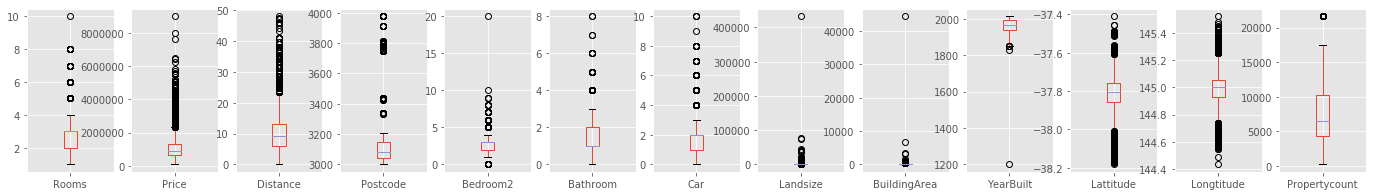

In [4]:
# melbourne_housing_raw.plot.box()
num_col = [i for i, t in melbourne_housing_raw.dtypes.to_frame('type').iterrows() if t.type in ['int64', 'float64'] ]
fig, ax = plt.subplots(1,len(num_col), figsize=(24,3))
for idx, col in enumerate(num_col):
    melbourne_housing_raw.loc[:, col].plot.box(ax = ax[idx])

# Using Geolocated Data
The dataset contains latitude and longitude. We will use a GeoData Frame

* We will have to install a few packages
* Plotting on a map provides additional insight

[1]Jordaan, A. C., Drost, B. E., & Makgata, M. A. (2004). Land value as a function of distance from the CBD: the case of the eastern suburbs of Pretoria. South African Journal of Economic and Management Sciences, 7(3), 532-541.

In [6]:

gdf = gpd.GeoDataFrame(
    melbourne_housing_raw, geometry=gpd.points_from_xy(melbourne_housing_raw.Longtitude, melbourne_housing_raw.Lattitude), 
    crs="EPSG:4326")
gdf = gdf.to_crs(epsg=3857)

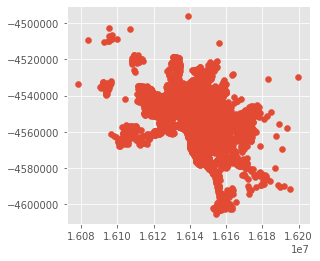

In [7]:
gdf.plot()

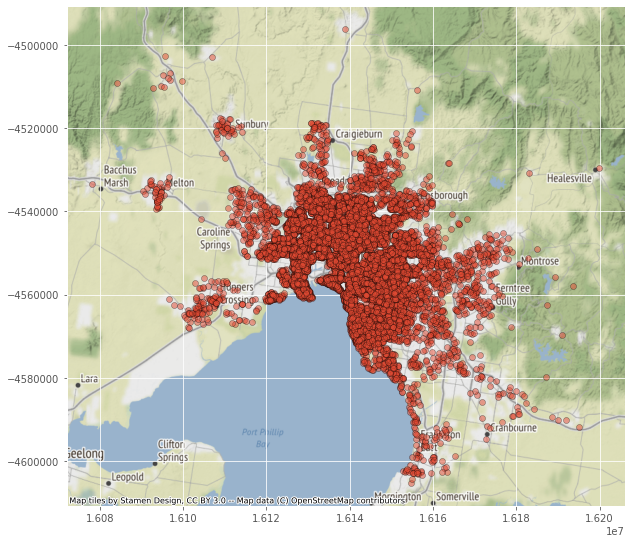

In [8]:
ax = gdf.plot(figsize=(10, 10), alpha=0.5, edgecolor='k')
ctx.add_basemap(ax)

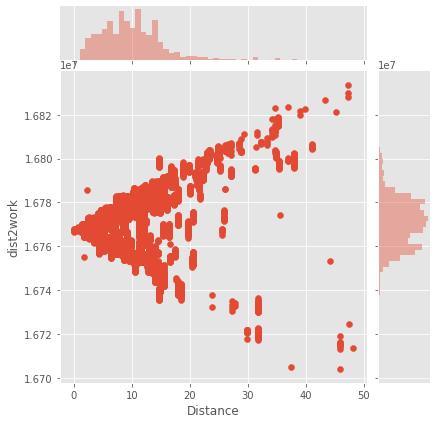

In [9]:

melbourne = Point(-37.813628, 144.963058)
gdf['dist2work'] = gdf.distance(melbourne)

data = gdf.loc[:,['Distance', 'dist2work']]
sns.jointplot(x='Distance', y ='dist2work', data=data)

## Filtering data 
    * df.loc[:,:]
    * df.iloc[:,:]
    * df.query("column > condition") this is equivalent to df[df.column > condition]

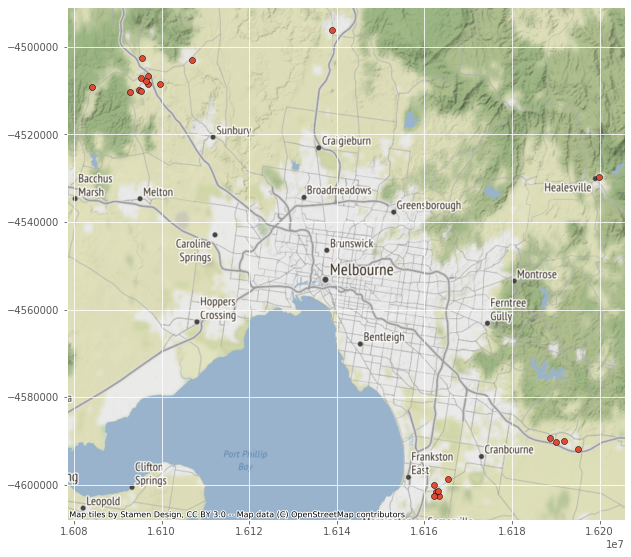

In [48]:
ax = gdf.query("Distance > 40").plot(figsize=(10, 10), alpha=1.0
                                     , edgecolor='k')
ctx.add_basemap(ax)
# circle1 = plt.Circle((1.6137e7, -4553000), 50000, color='r', fill=None, lw=2)
# ax.add_artist(circle1)


In [ ]:
X = gdf.loc[:,['Rooms', 'Bedroom2', 'Bathroom', 'Distance', 'Landsize', 'BuildingArea']]
y = gdf.loc[:,['Price']]

### Often times you will find one or more features have missing values

In [78]:
# Define model. Specify a number for random_state to ensure same results each run
melbourne_model = DecisionTreeRegressor(random_state=42)

# Fit model
try:
    melbourne_model.fit(X, y)
except Exception as err:
    print(str(err))

Input contains NaN, infinity or a value too large for dtype('float32').


In [12]:
print(gdf.shape)

(13580, 23)


### Option 1. drop missing rows

In [65]:
data = X.join(y).dropna(axis=0)
X = data.loc[:,['Rooms', 'Bedroom2', 'Bathroom', 'Distance', 'Landsize', 'BuildingArea']]
y = data.loc[:,['Price']]
melbourne_model = DecisionTreeRegressor(random_state=42)
melbourne_model.fit(X, y)

DecisionTreeRegressor(random_state=42)

In [66]:
print(data.shape)

(7130, 7)


In [67]:
print("Making predictions for the following 5 houses:")
print(X.head())
print("The predictions are")
print(melbourne_model.predict(X.head()))
print("The actual prices are")
print(y.head())

Making predictions for the following 5 houses:
   Rooms  Bedroom2  Bathroom  Distance  Landsize  BuildingArea
1      2       2.0       1.0       2.5     156.0          79.0
2      3       3.0       2.0       2.5     134.0         150.0
4      4       3.0       1.0       2.5     120.0         142.0
6      3       4.0       2.0       2.5     245.0         210.0
7      2       2.0       1.0       2.5     256.0         107.0
The predictions are
[1035000. 1465000. 1600000. 1876000. 1636000.]
The actual prices are
       Price
1  1035000.0
2  1465000.0
4  1600000.0
6  1876000.0
7  1636000.0


In [68]:
predicted_home_prices = melbourne_model.predict(X)
mean_absolute_error(y, predicted_home_prices)

1712.7676484338476

### Option 2. drop feature with missing values

In [69]:
pd.isnull(gdf.loc[:,['Rooms', 'Bedroom2', 'Bathroom', 'Distance', 'Landsize', 'BuildingArea', 'Price']]).sum()

Rooms              0
Bedroom2           0
Bathroom           0
Distance           0
Landsize           0
BuildingArea    6450
Price              0
dtype: int64

In [71]:

# Define model. Specify a number for random_state to ensure same results each run
melbourne_model = DecisionTreeRegressor(random_state=42)
X = gdf.loc[:,['Rooms', 'Bedroom2', 'Bathroom', 'Distance', 'Landsize']]
y = gdf.loc[:,['Price']]
# Fit model
melbourne_model.fit(X, y)

DecisionTreeRegressor(random_state=42)

In [72]:
predicted_home_prices = melbourne_model.predict(X)
mean_absolute_error(y, predicted_home_prices)

22247.089087951812

### Option 3. Impute missing values

In [73]:

X = gdf.loc[:,['Rooms', 'Bedroom2', 'Bathroom', 'Distance', 'Landsize', 'BuildingArea']]
y = gdf.loc[:,['Price']]
imputer = KNNImputer(n_neighbors=5)
Xfit = imputer.fit_transform(X)
Xfit = pd.DataFrame(data=Xfit, columns=X.columns, index= X.index )

In [74]:
melbourne_model.fit(Xfit, y)
predicted_home_prices = melbourne_model.predict(Xfit)
mean_absolute_error(y, predicted_home_prices)

9514.596045135648

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7ffaa4af0410>],
      dtype=object)

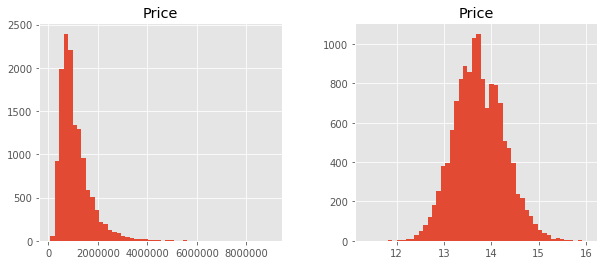

In [44]:
fig, ax = plt.subplots(1,2, figsize=(10,4))
y.hist(bins=50, ax=ax[0])
np.log(y).hist(bins=50, ax=ax[1])

In [76]:
melbourne_model.fit(Xfit, np.log(y))
predicted_home_prices = melbourne_model.predict(Xfit)
mean_absolute_error(y, np.exp(predicted_home_prices))

9403.03697992557

### Better fitting
    * More training Data
    * better features

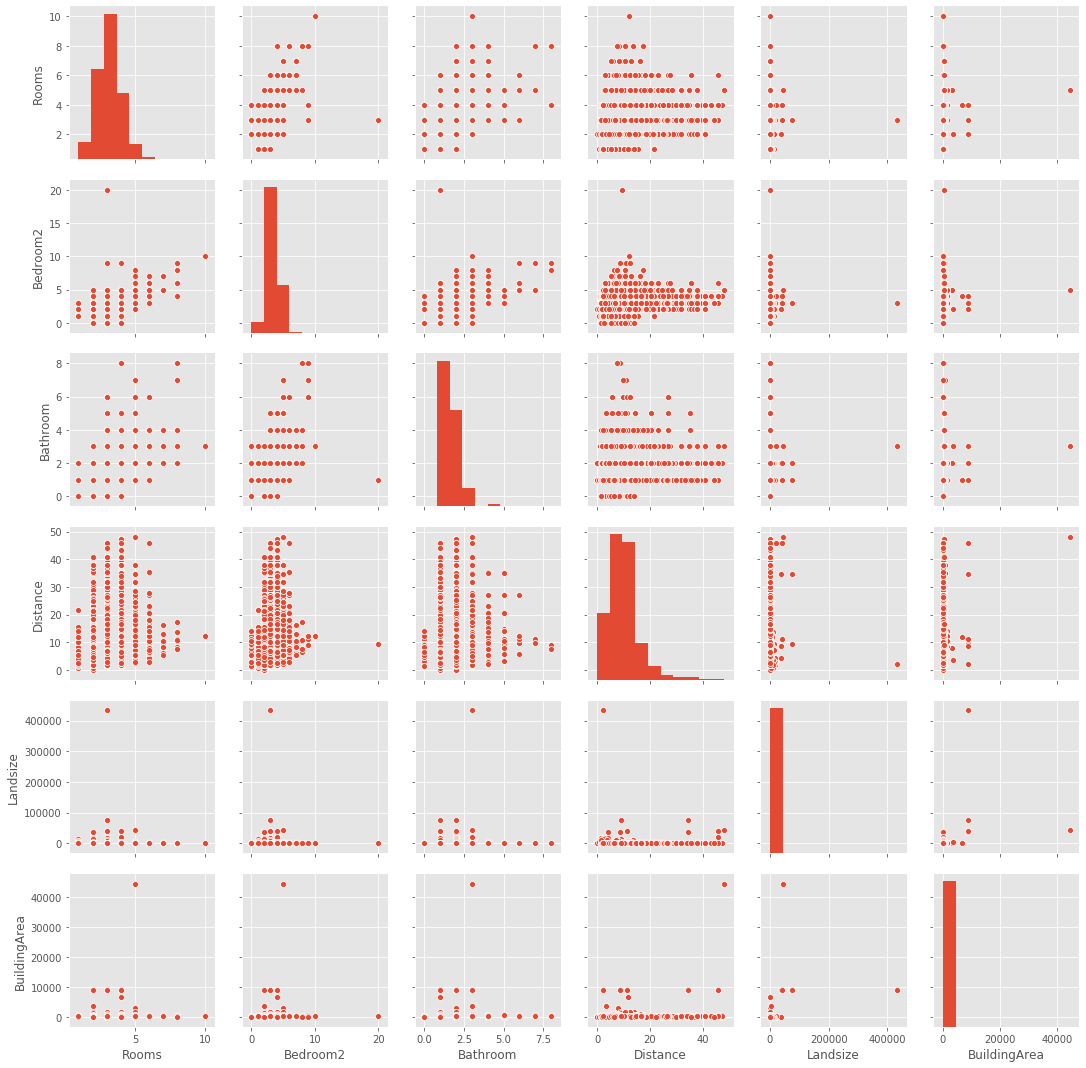

In [46]:
sns.pairplot(Xfit)

## Validating the model
split available data into train and test

In [88]:
train_X, test_X, train_y, test_y = train_test_split(Xfit, y, test_size=0.20, random_state = 42)

In [91]:
melbourne_model_xgb_train = xgb.DMatrix(data = train_X, label = train_y) 
melbourne_model_xgb_test  = xgb.DMatrix(data = test_X,  label = test_y)  
param = {'max_depth': 2, 
         'eta': 1, 
         'objective': 'reg:squaredlogerror',
         'eval_metric': 'mae'}
evallist = [(melbourne_model_xgb_test, 'test'), (melbourne_model_xgb_train, 'train')]
num_round = 10
bst = xgb.train(param, melbourne_model_xgb_train, num_round, evallist)
test_ypred = bst.predict(melbourne_model_xgb_test)

[0]	test-mae:1078556.87500	train-mae:1074960.12500
[1]	test-mae:1078555.50000	train-mae:1074959.37500
[2]	test-mae:1078550.00000	train-mae:1074954.00000
[3]	test-mae:1078540.62500	train-mae:1074944.25000
[4]	test-mae:1078523.25000	train-mae:1074927.12500
[5]	test-mae:1078486.00000	train-mae:1074890.00000
[6]	test-mae:1078421.87500	train-mae:1074825.62500
[7]	test-mae:1078316.62500	train-mae:1074721.50000
[8]	test-mae:1078180.75000	train-mae:1074585.50000
[9]	test-mae:1078044.62500	train-mae:1074448.12500


In [92]:
mean_absolute_error(test_y, test_ypred)

1078046.1779927183